In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, LSTM, MaxPooling2D, Reshape, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

In [12]:
# NEED TO MAKE IMAGES 512x512 to enable all the 2x downsampling/upsampling to go correctly

DATA_DIRNAME = Path('/home/sergeyk/work/iamdb')

crop_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped').glob('*.jpg')))
gt_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped-gt').glob('*.png')))

print(len(crop_filenames))

NUM_LABELS = 2

X = []
Y = []
for ind in range(len(crop_filenames)):
    name = crop_filenames[ind].stem
    image = cv2.imread(str(crop_filenames[ind]), cv2.IMREAD_GRAYSCALE)
    
    gt_filename = DATA_DIRNAME / 'forms-cropped-gt' / f'{name}.png'
    gt_image = cv2.imread(str(gt_filename), cv2.IMREAD_GRAYSCALE)

    # make it an even width
    image = image[1:]
    gt_image = gt_image[1:]
    
    # only have three labels: background, odd lines, even lines
    for value in np.unique(gt_image):
        gt_image[gt_image == (value + 1)] = value % 2 + 1
    
    # get rid of even lines
    gt_image[gt_image == 2] = 0
    
    X.append(image / 255)
    Y.append(to_categorical(gt_image, NUM_LABELS))
    
X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.uint8)
print(X.shape, X.dtype, Y.shape, Y.dtype)

# For training
X_train = X[:1000]
X_test = X[1000:]
Y_train = Y[:1000]
Y_test = Y[1000:]

# For overfitting
X_single = np.repeat(X[0:1], X.shape[0], axis=0)
Y_single = np.repeat(Y[0:1], Y.shape[0], axis=0)

1537
(1537, 632, 620) float32 (1537, 632, 620, 2) uint8


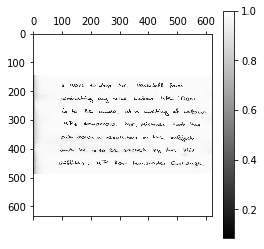

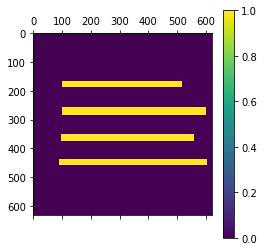

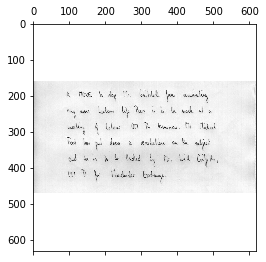

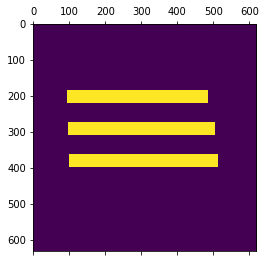

In [13]:
MAX_HEIGHT, MAX_WIDTH = X[0].shape

plt.matshow(X[0], cmap='gray')
plt.colorbar()

plt.matshow(Y[0].reshape((MAX_HEIGHT, MAX_WIDTH, NUM_LABELS)).argmax(axis=-1))
plt.colorbar()

plt.matshow(X[1], cmap='gray')
plt.matshow(Y[1].reshape((MAX_HEIGHT, MAX_WIDTH, NUM_LABELS)).argmax(axis=-1))

In [15]:
# This is a U-net'y kind of net.

def conv_block(inputs, num_filters, kernel_size, activation, batch_norm=False):
    conv = Conv2D(num_filters, kernel_size=kernel_size, use_bias=(not batch_norm), padding='same')(inputs)
    if batch_norm:
        conv = BatchNormalization()(conv)
    return Activation(activation)(conv)

input_image = Input((MAX_HEIGHT, MAX_WIDTH))
input_image_reshaped = Reshape((MAX_HEIGHT, MAX_WIDTH, 1))(input_image)

initial_conv = conv_block(input_image_reshaped, 32, 3, 'relu')
conv = conv_block(initial_conv, 32, 3, 'relu')
pool1 = MaxPooling2D(2, padding='same')(conv)

conv = conv_block(pool1, 64, 3, 'relu')
conv = conv_block(conv, 64, 3, 'relu')
pool2 = MaxPooling2D(2, padding='same')(conv)

conv = conv_block(pool2, 128, 3, 'relu')
conv = conv_block(conv, 128, 3, 'relu')
pool3 = MaxPooling2D(2, padding='same')(conv)

conv = conv_block(pool3, 256, 3, 'relu')
conv = conv_block(conv, 256, 3, 'relu')
pool4 = MaxPooling2D(2, padding='same')(conv)

conv = conv_block(pool4, 512, 3, 'relu')
conv = conv_block(conv, 512, 3, 'relu')

# up = UpSampling2D(2)(conv)
# cat = Concatenate(axis=-1)([pool3, up])
# conv = conv_block(cat, 256, 3, 'relu')
# conv = conv_block(conv, 256, 3, 'relu')

# up = UpSampling2D(2)(conv)
# cat = Concatenate(axis=-1)([pool2, up])
# conv = conv_block(cat, 128, 3, 'relu')
# conv = conv_block(conv, 128, 3, 'relu')

# up = UpSampling2D(2)(conv)
# cat = Concatenate(axis=-1)([pool1, up])
# conv = conv_block(cat, 64, 3, 'relu')
# conv = conv_block(conv, 64, 3, 'relu')

# up = UpSampling2D(2)(conv)
# cat = Concatenate(axis=-1)([initial_conv, up])
# conv = conv_block(conv, 32, 3, 'relu')
# conv = conv_block(conv, 32, 3, 'relu')

# conv = conv_block(conv, 16, 1, 'relu')
# pred = conv_block(conv, NUM_LABELS, 1, 1, 'softmax')

output = Reshape((MAX_HEIGHT * MAX_WIDTH, NUM_LABELS))(conv)
model = Model(inputs=input_image, outputs=output)
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3)
]
history = model.fit(
    x=X_single,
    y=Y_single,
    epochs=32,
    batch_size=16,
    validation_data=(X_test, Y_test),
    callbacks=callbacks
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 632, 620)          0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 632, 620, 1)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 632, 620, 32)      320       
_________________________________________________________________
activation_64 (Activation)   (None, 632, 620, 32)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 632, 620, 32)      9248      
_________________________________________________________________
activation_65 (Activation)   (None, 632, 620, 32)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 316, 310, 32)      0         
__________

ValueError: Error when checking target: expected reshape_8 to have 3 dimensions, but got array with shape (1537, 632, 620, 2)

In [8]:
model.evaluate(X_test, Y_test, batch_size=16)

NameError: name 'X_test' is not defined

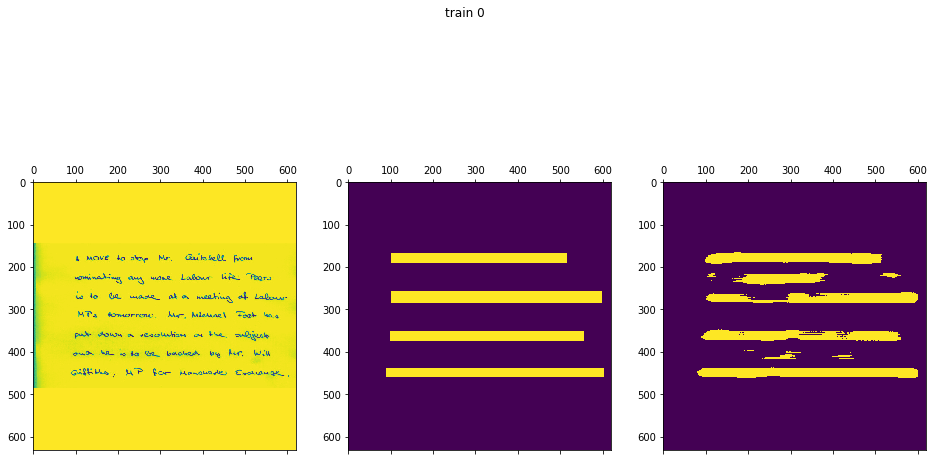

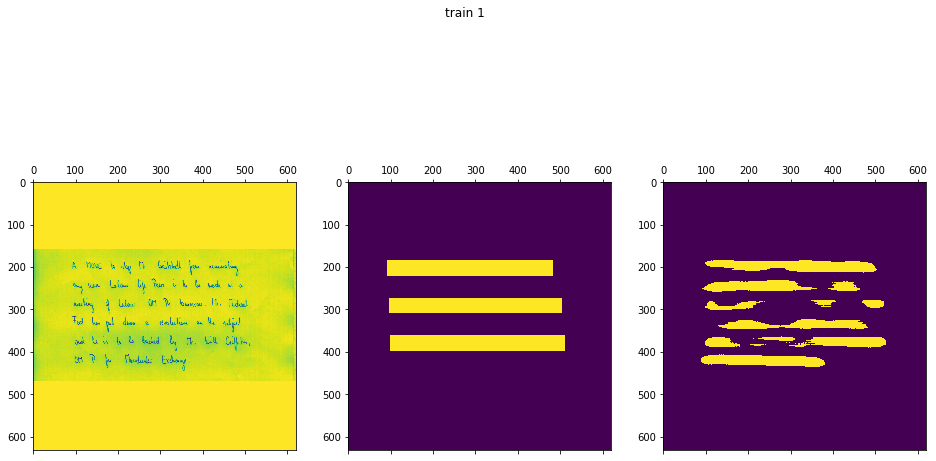

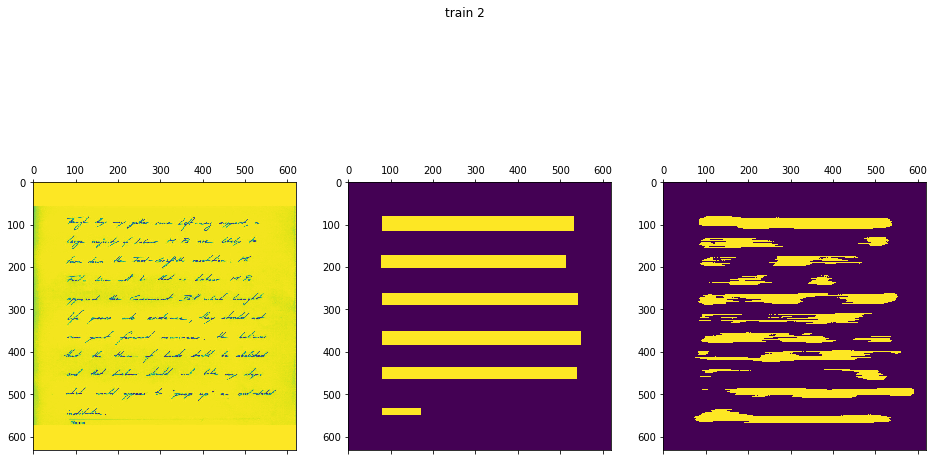

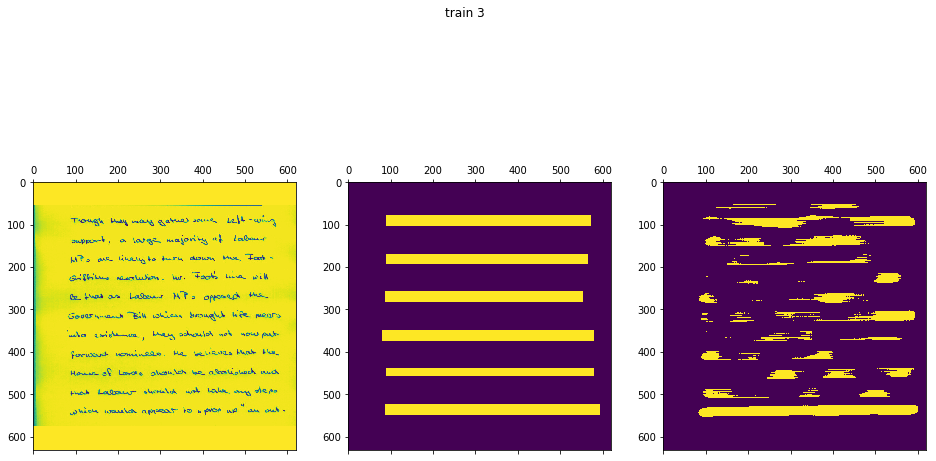

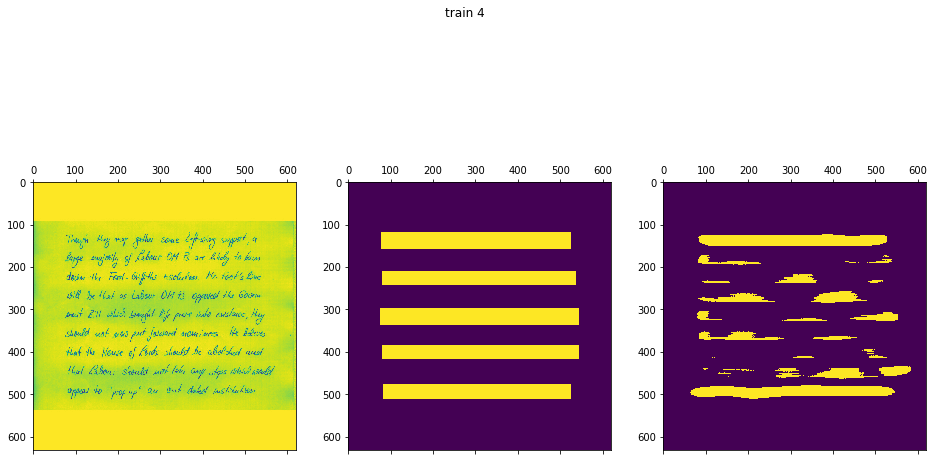

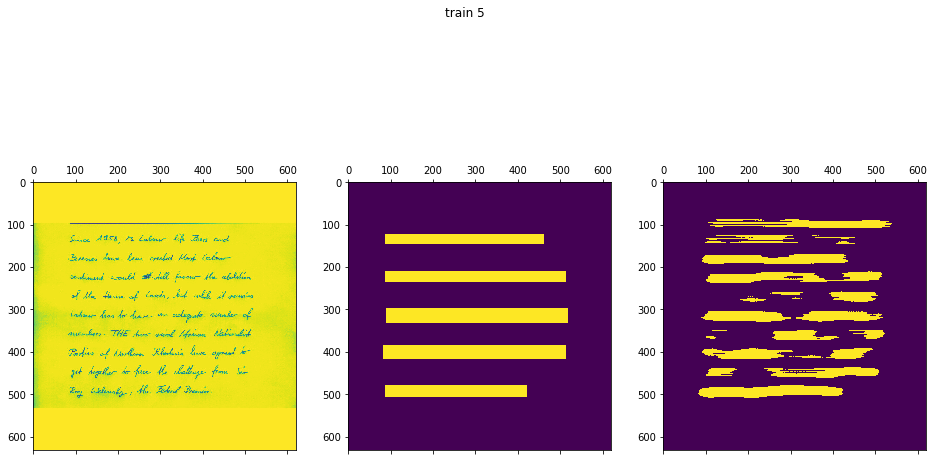

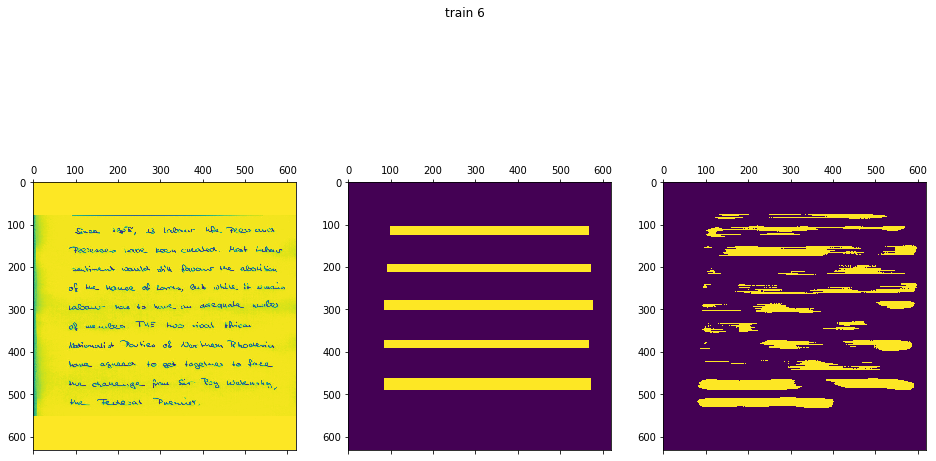

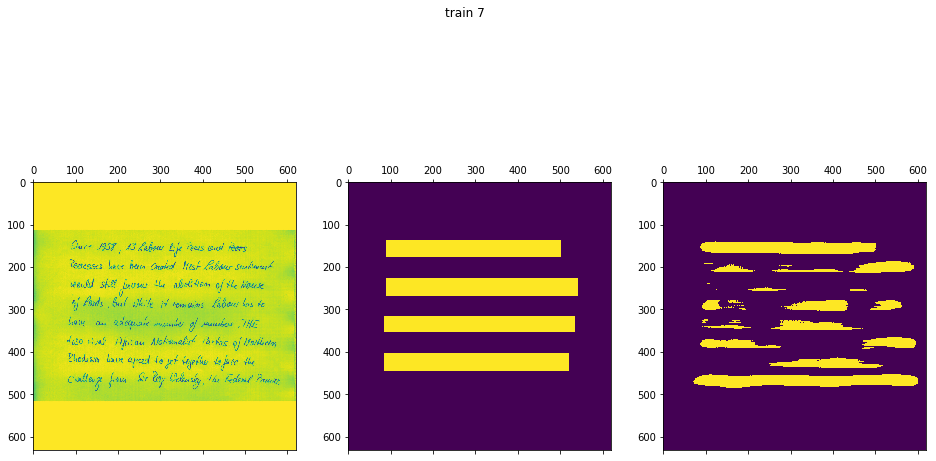

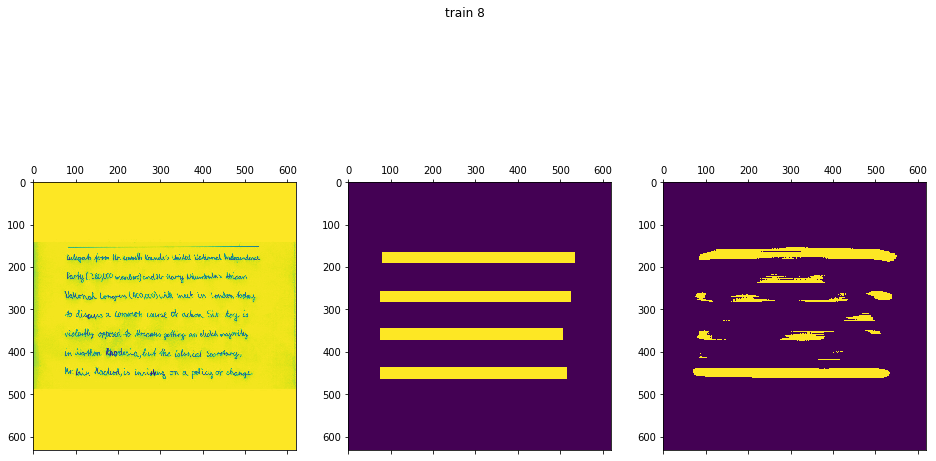

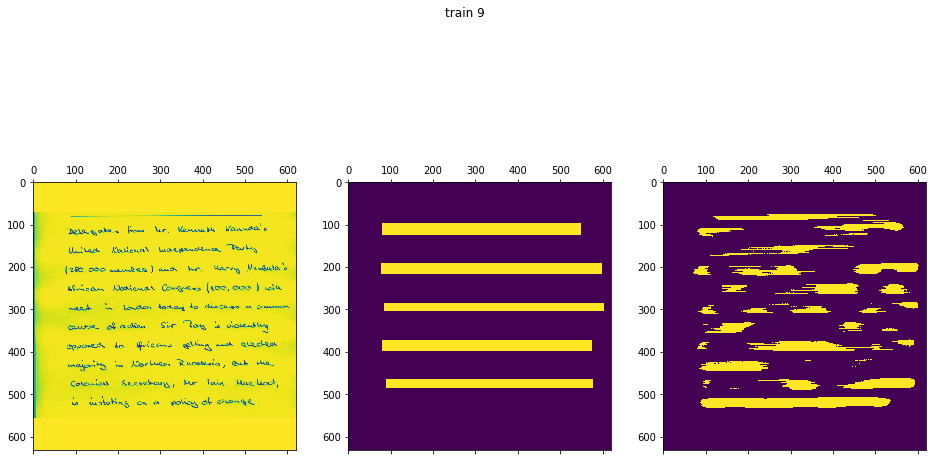

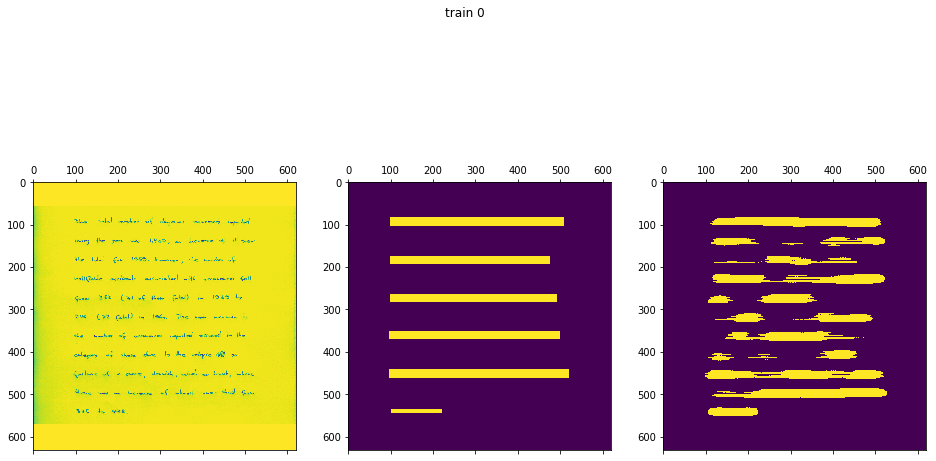

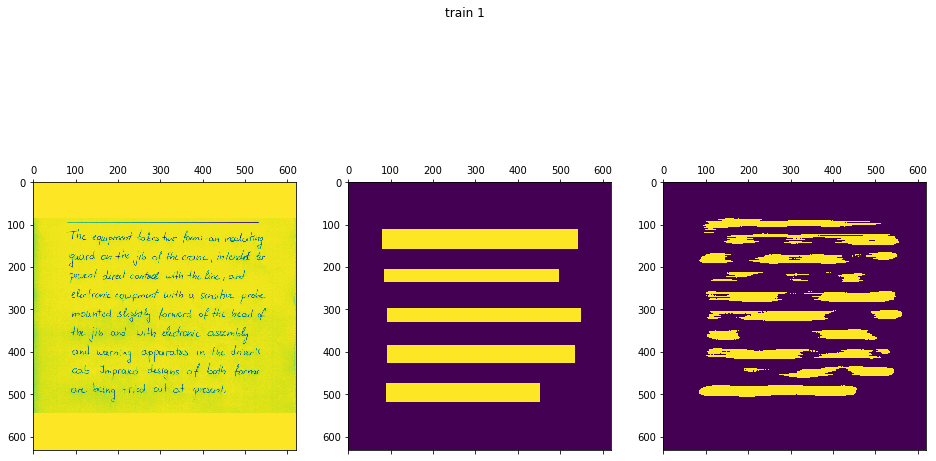

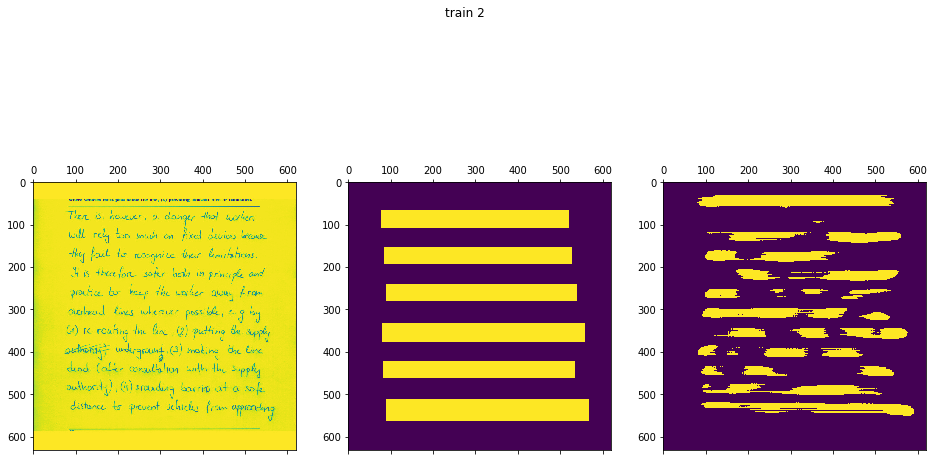

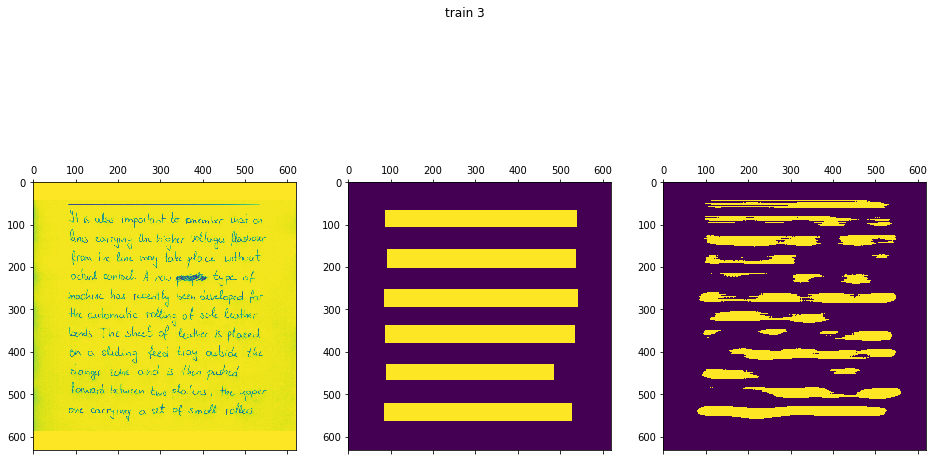

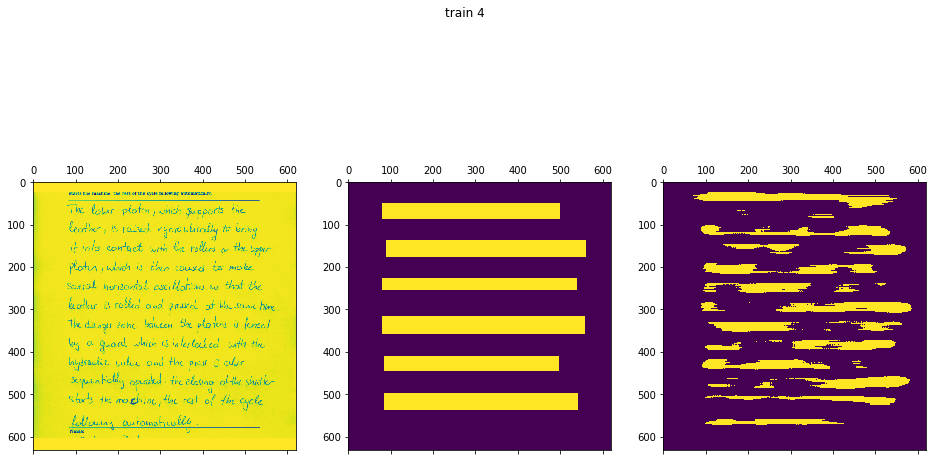

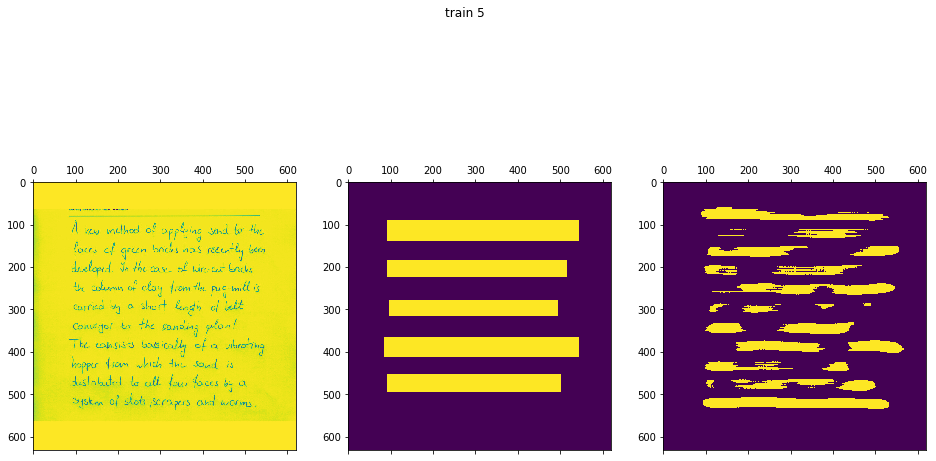

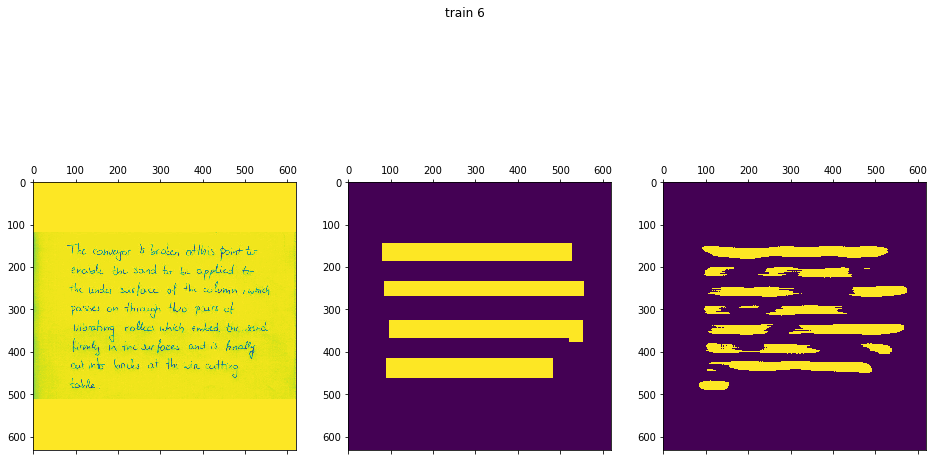

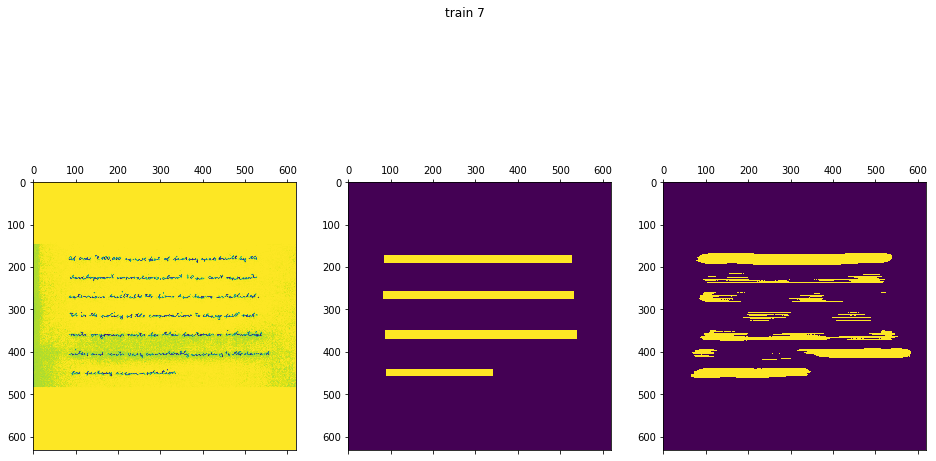

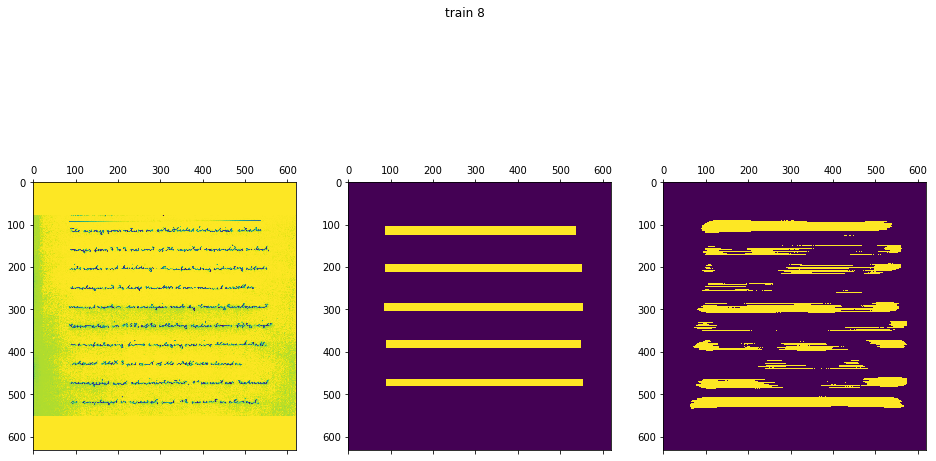

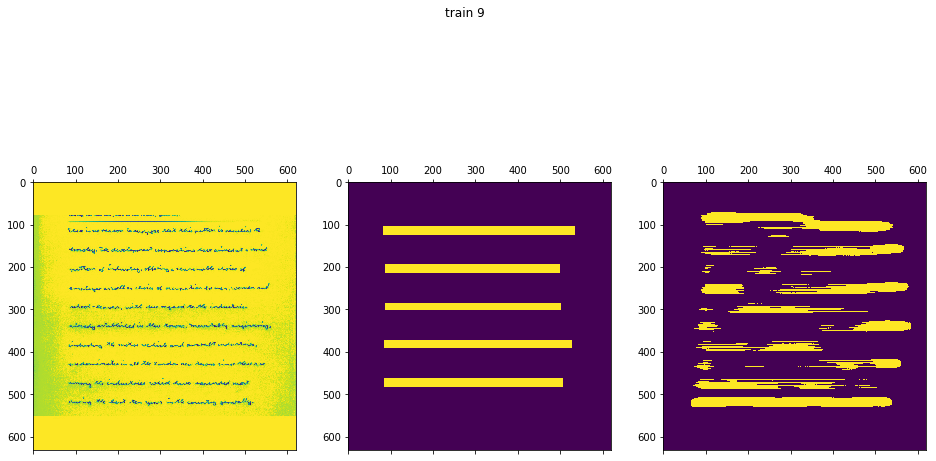

In [22]:
def plot_gt_and_pred(X, Y, preds, ind, split_name):
    gt = Y[ind].reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    pred = preds[ind].reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f'{split_name} {ind}')
    ax1 = fig.add_subplot(131)
    ax1.matshow(X[ind].squeeze())
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt)
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred)

NUM_TO_PRED = 10
train_preds = model.predict(X[:NUM_TO_PRED])
for ind in range(NUM_TO_PRED):
    plot_gt_and_pred(X, Y, train_preds, ind, 'train')

test_preds = model.predict(X_test[:NUM_TO_PRED])
for ind in range(NUM_TO_PRED):
    plot_gt_and_pred(X_test, Y_test, test_preds, ind, 'train')